## Imports

In [1]:
import pandas as pd
import math
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from tqdm import tqdm_notebook as tqdm
from boruta import BorutaPy
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
import warnings
from matplotlib import pyplot as plt

## Data Read-in

In [2]:
probes = pd.read_csv('probes.csv',sep='\t', encoding='utf-8', header=None)
probes.columns = ['id','created_at','updated_at','deleted_at','timestamp',
                  'user_id','answer','page_nr','delay_time','time_to_answer']


questionnaires = pd.DataFrame(columns=['id','created_at','updated_at','deleted_at','screen_width',
                                      'screen_height','age','gender','level_of_education',
                                      'using_mouse','read_war_and_peace','read_grimm'])

with open('questionnaires.csv','r',encoding='utf-8') as f:
    for line in f:
        spl = line[1:-2].split('\t')
        questionnaires = questionnaires.append(pd.DataFrame(np.array(spl).reshape(1,-1),columns=['id','created_at','updated_at','deleted_at','screen_width',
                                      'screen_height','age','gender','level_of_education',
                                      'using_mouse','read_war_and_peace','read_grimm']))

questions = pd.read_csv('questions.csv',sep='\t', encoding='utf-8', header=None)
questions.columns = ['id','created_at','updated_at','deleted_at','user_id',
                     'correct','page_nr','book']

records = pd.read_csv('records.csv',sep='\t', encoding='utf-8', header=None)
records.columns= ['id','created_at','updated_at', 'deleted_at','timestamp','user_id',
                 'clicked_left', 'clicked_right','on_screen','screen_loc','x','y',
                 'screen_width','screen_height']

## Some relevant statistics

# participants total:34
# female:19, # male:15
average age:30
median age:25
71.4% not mindwandering, 28.6% mindwandering
# users who started experiment: 29, # users who finished experiment: 24
# valid users read war and peace: 14, # valid who read Grimm: 10


([<matplotlib.patches.Wedge at 0x2bda55d9080>,
 [Text(0.741065,0.81291,'bachelors'),
  Text(-0.490312,0.98468,'high_education'),
  Text(-0.397366,-1.02572,'masters')])

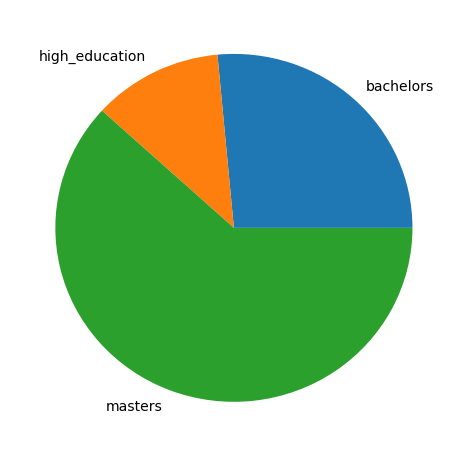

In [3]:
labels = np.array([0 if val.answer in [1,2] else 1 for _,val in probes.iterrows()])

print('# participants total:{}'.format(len(questionnaires)))

gen,count = np.unique(questionnaires.gender,return_counts=True)
print('# female:{}, # male:{}'.format(count[0], count[1]))

print('average age:{}'.format(round(questionnaires.age.astype(int).mean()),2))
print('median age:{}'.format(round(questionnaires.age.astype(int).median()),2))

_,count = np.unique(labels,return_counts=True)
percs = np.round(count/np.sum(count)*100,1)
print("{}% not mindwandering, {}% mindwandering".format(percs[0], percs[1]))

# users who did not finish the experiment
usrs_all = np.unique(probes.user_id)
blacklist = usrs_all[np.array([len(probes.user_id.loc[probes.user_id==usr]) for usr in usrs_all])<6]
print("# users who started experiment: {}, # users who finished experiment: {}".format(len(usrs_all), len(usrs_all)-len(blacklist)))

usrs = np.array([x for x in usrs_all if x not in blacklist and not np.isnan(x)])

tol_gr = []
for us_idx in usrs:
    tol_gr.append(0 if questions.loc[questions.user_id==us_idx,'correct'].iloc[0] == 'war_and_peace' else 1)

_,prop_texts = np.unique(tol_gr, return_counts=True)
print('# valid users read war and peace: {}, # valid who read Grimm: {}'.format(prop_texts[0], prop_texts[1]))


plt.figure(figsize=(8,8))
lab,count = np.unique(questionnaires.level_of_education,return_counts=True)
plt.pie(count, labels=lab, textprops={'fontsize': 14})

## Processing pipe

In [4]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, feat_sel = []):
        self.feat_sel = feat_sel
        pass
    
    def _normalize_coords(self, df):
        df['x_norm'] = df.x/df.screen_width
        df['y_norm'] = df.y/df.screen_height
        loc_norm = []
        for usr in np.unique(df.user_id):
            df_usr = df.loc[df.user_id==usr]
            loc_norm = loc_norm+list(df_usr.screen_loc/df_usr.screen_loc.max())
        df['loc_norm'] = loc_norm
        return df

    def _get_polar(self, df):
        df['cur_polar'] = np.arctan2(list(df.y_norm),list(df.x_norm))
        df['cur_velocity'] = np.sqrt(list(df.x_norm**2 + df.y_norm**2))
        return df

    def _get_trajectories(self,df):
        traj_loc = []
        traj_pol =  []
        traj_velocity = []
        for usr in np.unique(df.user_id):
            df_usr = df.loc[df.user_id==usr]
            traj_loc = traj_loc + list(df_usr.loc_norm.rolling(2).apply(lambda x: x[1]-x[0],raw=True))
            traj_x = df_usr.x_norm.rolling(2).apply(lambda x: x[1]-x[0],raw=True)
            traj_y = df_usr.y_norm.rolling(2).apply(lambda x: x[1]-x[0],raw=True)
            traj_pol = traj_pol + list(np.arctan2(traj_x,traj_y))
            traj_velocity = traj_velocity + list(np.sqrt(np.array(traj_x)**2+ np.array(traj_y)**2))
            
        df['traj_loc'] = traj_loc
        df['traj_pol'] = traj_pol
        df['traj_velocity'] = traj_velocity
        return df
    
    def _get_hesitation(self,df):
        hesitation = []
        for user in np.unique(df.user_id):
            df_usr = df.loc[df.user_id==user].sort_values('id')
            timepts = pd.to_datetime(df_usr.timestamp)
            a = pd.to_datetime([np.nan]+list(df_usr.timestamp))
            b = pd.to_datetime(list(df_usr.timestamp)+[np.nan])
            c = list((b-a).seconds)
            hesitation = hesitation + c[:-1]
        df['hesitation'] = hesitation
        return df
    
    def _slice_probe_windows(self, df):
        # interval length = 30 seconds
        intervals = []
        for _,probe in probes.iterrows():
            FMT = '%Y-%m-%d %H:%M:%S'
            ts = pd.Timestamp(probe.timestamp)
            usr = probe.user_id
            if usr in np.unique(df.user_id):
                ts_int = pd.Interval(ts-pd.Timedelta(30,unit='seconds'),ts,closed='both')
                # Get cumulative clicks
                df_int = df.loc[np.logical_and(df.user_id==usr,
                                               [x in ts_int for x in pd.to_datetime(df.timestamp)])].copy()
                # if empty slice (only on invalid subjects)
                df_int['cur_spec'] = [np.max(np.abs(np.fft.fft(df_int.cur_velocity)))]*len(df_int)
                df_int['traj_spec'] = [np.max(np.abs(np.fft.fft(df_int.traj_velocity)))]*len(df_int)
                intervals.append(df_int[[#'x_norm','y_norm','loc_norm',
                    'cur_polar','cur_velocity','hesitation',
                    'traj_loc','traj_pol','traj_velocity','clicked_right','clicked_left',
                    'cur_spec', 'traj_spec'
                ]])
        return intervals
    
    def _average_windows(self, df):
        res_mat = pd.DataFrame(columns=df[0].columns)
        for interv in df:
            res_mat = res_mat.append(pd.DataFrame(np.array(interv.mean()).reshape(1,len(df[0].columns)),
                                                  columns=df[0].columns))
        return res_mat
    
    def _feature_select(self, df):
        return df.drop(columns=self.feat_sel)
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        res_mat = X.copy()
        res_mat = self._normalize_coords(res_mat)
        res_mat = self._get_polar(res_mat)
        res_mat = self._get_trajectories(res_mat)
        res_mat = self._get_hesitation(res_mat)
        res_mat = self._slice_probe_windows(res_mat)
        res_mat = self._average_windows(res_mat)
        res_mat = self._feature_select(res_mat)
        return res_mat

## Feature Selection

In [5]:
X = records.loc[[x in usrs for x in records.user_id]]
y = labels[[x in usrs for x in probes.user_id]]
prep = Preprocessor()
X = prep.transform(X)

In [6]:
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1, class_weight='balanced', max_depth=3)
featsel = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42, perc=90)
featsel.fit(np.array(X),y)
mask = featsel.support_
disc = [x for idx, x in enumerate(X.columns) if not mask[idx]]
print('Features discarded:{}'.format(disc))
print(featsel.ranking_)

Features discarded:['cur_polar', 'cur_velocity', 'hesitation', 'traj_pol', 'traj_velocity', 'clicked_right', 'clicked_left', 'cur_spec', 'traj_spec']
[ 3  6  7  1  4  9 10  2  5  8]


In [7]:
for ranking in range(1,max(featsel.ranking_)+1):
    print([X.columns[idx] for idx in np.where(featsel.ranking_==ranking)])

[Index(['traj_loc'], dtype='object')]
[Index(['clicked_left'], dtype='object')]
[Index(['cur_polar'], dtype='object')]
[Index(['traj_pol'], dtype='object')]
[Index(['cur_spec'], dtype='object')]
[Index(['cur_velocity'], dtype='object')]
[Index(['hesitation'], dtype='object')]
[Index(['traj_spec'], dtype='object')]
[Index(['traj_velocity'], dtype='object')]
[Index(['clicked_right'], dtype='object')]


## Do analysis

In [8]:
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1, class_weight='balanced', max_depth=3)
featsel = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42, perc=10)
featsel.fit(np.array(X),y)
mask = featsel.support_
disc = [x for idx, x in enumerate(X.columns) if not mask[idx]]
print('Features discarded:{}'.format(disc))

Features discarded:['traj_velocity', 'clicked_right']


In [9]:
# Convergence warning and only 1 label found in test warning
#warnings.filterwarnings("ignore")


prec, rec, f1, acc = [],[],[],[]
prec_rand, rec_rand, f1_rand, acc_rand = [],[],[],[]

idx = 0
kf = KFold(n_splits=8, shuffle=True)
for train, test in tqdm(kf.split(usrs)):
    X_train = records.loc[[x in usrs[train] for x in records.user_id]]
    X_test = records.loc[[x in usrs[test] for x in records.user_id]]
    y_train = labels[[x in usrs[train] for x in probes.user_id]]
    y_test = labels[[x in usrs[test] for x in probes.user_id]]
    pipe = Pipeline(steps = [('preprocessing', Preprocessor(feat_sel=disc)),
                             ('clf', rf)]).fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_pred_train = pipe.fit(X_train,y_train).predict(X_train)
    
    idx+=1
    
    acc.append(accuracy_score(y_test,y_pred))
    trials = np.random.rand(100,len(y_test))<0.5

    acc_rand.append(np.mean([accuracy_score(y_test,trial) for trial in trials]))
    
    f1.append(f1_score(y_test, y_pred, average='macro')) 
    prec.append(precision_score(y_test, y_pred, average='macro'))
    rec.append(recall_score(y_test, y_pred, average='macro'))
    print('Left-out subjects:{}, F1-score:{}, Precision:{}, Recall:{}, Accuracy:{}'.format(usrs[test],
                                                                              round(f1[-1],3),
                                                                              round(prec[-1],3),
                                                                              round(rec[-1],3),
                                                                              round(acc[-1],3)))
    f1_rand.append(np.mean([f1_score(y_test,  trial) for trial in trials]))
    prec_rand.append(np.mean([precision_score(y_test,  trial) for trial in trials]))
    rec_rand.append(np.mean([recall_score(y_test,  trial,) for trial in trials]))
    
print('Average F1:{}, average Precision: {}, average Recall: {}, average Accuracy'.format(round(np.mean(f1),3), 
                                                                                          round(np.mean(prec),3),
                                                                                          round(np.mean(rec),3),
                                                                                          round(np.mean(acc),3)))

print('Random baseline: F1:{}, precision:{}, recall:{}, accuracy:{}'.format(round(np.mean(f1_rand),3), 
                                                               round(np.mean(prec_rand),3), 
                                                               round(np.mean(rec_rand),3),
                                                               round(np.mean(acc_rand),3)))


Left-out subjects:[11. 18. 33.], F1-score:0.379, Precision:0.367, Recall:0.393, Accuracy:0.611


C:\Users\fwalo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fwalo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Left-out subjects:[ 2. 10. 17.], F1-score:0.424, Precision:0.368, Recall:0.5, Accuracy:0.737
Left-out subjects:[ 7. 24. 26.], F1-score:0.608, Precision:0.608, Recall:0.608, Accuracy:0.8
Left-out subjects:[ 3. 16. 19.], F1-score:0.63, Precision:0.844, Recall:0.643, Accuracy:0.722
Left-out subjects:[15. 25. 30.], F1-score:0.411, Precision:0.5, Recall:0.5, Accuracy:0.5
Left-out subjects:[ 4.  6. 27.], F1-score:0.455, Precision:0.469, Recall:0.441, Accuracy:0.833


C:\Users\fwalo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\fwalo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Left-out subjects:[ 5.  9. 14.], F1-score:0.333, Precision:0.25, Recall:0.5, Accuracy:0.5
Left-out subjects:[22. 23. 32.], F1-score:0.663, Precision:0.708, Recall:0.688, Accuracy:0.667

Average F1:0.488, average Precision: 0.514, average Recall: 0.534, average Accuracy
Random baseline: F1:0.323, precision:0.28, recall:0.5, accuracy:0.503


Significance? p=0.0164


C:\Users\fwalo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'f1-score')

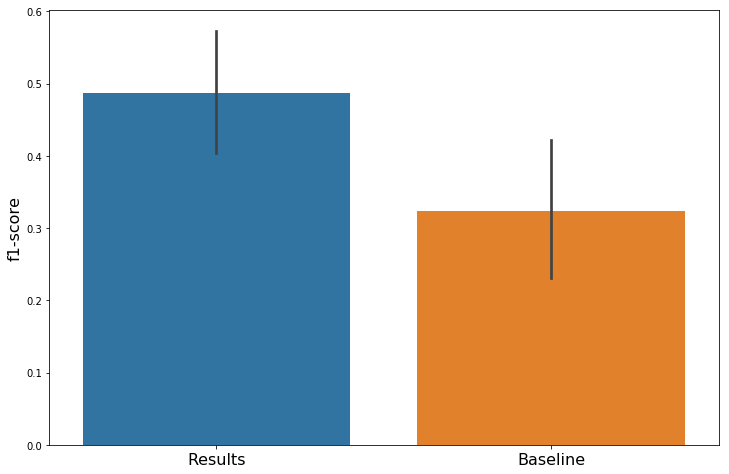

In [10]:
import seaborn as sns
import scipy 
res = scipy.stats.ttest_rel(f1,f1_rand)
# since 1 sided
print('Significance? p={}'.format(round(res.pvalue/2,4)))

res = pd.DataFrame()
res['Results'] = f1
res['Baseline'] = f1_rand
plt.figure(figsize=(12,8))
plt.xticks(fontsize=16)
sns.barplot(data=res)
plt.ylabel('f1-score',fontsize=16)

Significance? p=0.0036


C:\Users\fwalo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Accuracy')

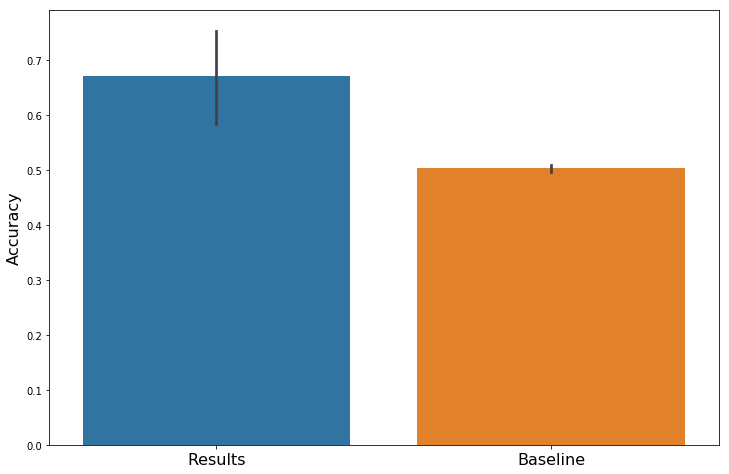

In [11]:
import seaborn as sns
import scipy 
res = scipy.stats.ttest_rel(acc,acc_rand)
# since 1 sided
print('Significance? p={}'.format(round(res.pvalue/2,4)))


res = pd.DataFrame()
res['Results'] = acc
res['Baseline'] = acc_rand
plt.figure(figsize=(12,8))
plt.xticks(fontsize=16)
sns.barplot(data=res)
plt.ylabel('Accuracy',fontsize=16)
